## Task: Semi-Supervised Learning

In [1]:
import numpy as np
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

labelled = unpickle('cifar-10-python/cifar-10-batches-py/data_batch_1')
X_labelled = (np.reshape(labelled[b'data'], (-1, 3, 32, 32)).transpose(0, 2, 3, 1)).astype(np.uint8)
y_labelled = np.array(labelled[b'labels'])

X_unlabelled = []
for i in range(2, 6):
    print(i)
    x1 = unpickle('cifar-10-python/cifar-10-batches-py/data_batch_'+str(i))
    x2 = x1[b'data']
    X_unlabelled = X_unlabelled + x2.tolist()
X_unlabelled = np.array(X_unlabelled)
X_unlabelled = np.reshape(X_unlabelled, (-1, 3, 32, 32))
X_unlabelled = X_unlabelled.transpose(0, 2, 3, 1)
X_unlabelled = X_unlabelled.astype(np.uint8)

test = unpickle('cifar-10-python/cifar-10-batches-py/test_batch')
X_test = (np.reshape(test[b'data'], (-1, 3, 32, 32)).transpose(0, 2, 3, 1)).astype(np.uint8)
y_test = np.array(test[b'labels'])

2
3
4
5


In [5]:
X_labelled.shape, y_labelled.shape

((10000, 32, 32, 3), (10000,))

In [6]:
X_unlabelled.shape

(40000, 32, 32, 3)

In [7]:
X_test.shape, y_test.shape

((10000, 32, 32, 3), (10000,))

## Base Model 

In [8]:
import keras
from keras.layers import Conv2D, BatchNormalization, Input, Dense, Flatten
from keras.models import Model, load_model

Using TensorFlow backend.


In [9]:
def BaseModel():
    X_input = Input((32, 32, 3))
    X = Conv2D(32, (3, 3), strides=(2, 2), activation="relu", padding="SAME")(X_input)
    X = BatchNormalization()(X)
    X = Conv2D(64, (3, 3), strides=(2, 2), activation="relu", padding="SAME")(X)
    X = BatchNormalization()(X)
    X = Conv2D(128, (3, 3), strides=(2, 2), activation="relu", padding="SAME")(X)
    X = BatchNormalization()(X)
    X = Flatten()(X)
    X = Dense(10, activation="softmax")(X)
    return Model(X_input, X)
base_model = BaseModel()
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 128)         512       
__________

In [10]:
# Normalise 
X_labelled_n = X_labelled / 255.
X_test_n = X_test / 255.

In [11]:
nvalues = 10
y_labelled_encoded = np.eye(nvalues)[y_labelled]

In [12]:
base_model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
## Upgrade to Keras 2.2.3+
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', restore_best_weights=True)

In [14]:
points = 250

In [15]:
base_model.fit(X_labelled_n[:points], y_labelled_encoded[:points], epochs=10, batch_size=128, validation_split=0.2, callbacks=[callback])

Train on 200 samples, validate on 50 samples
Epoch 1/10
200/200 [==============================] - 4s 19ms/step - loss: 2.8015 - acc: 0.0950 - val_loss: 2.5904 - val_acc: 0.2000
Epoch 2/10
200/200 [==============================] - 0s 509us/step - loss: 1.3430 - acc: 0.5350 - val_loss: 2.6089 - val_acc: 0.1800
Epoch 3/10
200/200 [==============================] - 0s 575us/step - loss: 0.6886 - acc: 0.8400 - val_loss: 2.6157 - val_acc: 0.2200
Epoch 4/10
200/200 [==============================] - 0s 580us/step - loss: 0.3351 - acc: 0.9650 - val_loss: 2.6052 - val_acc: 0.2000


In [16]:
base_model.evaluate(X_test_n, np.eye(nvalues)[y_test])

10000/10000 [==============================] - 2s 207us/step


[2.644049737930298, 0.1774]

In [17]:
del X_labelled_n, X_test_n

## Autoencoders

In [18]:
### Autoencoders
from keras.layers import Conv2DTranspose
def Encoder():
    X_input = Input((32, 32, 3))
    X = Conv2D(32, (3, 3), strides=(2, 2), activation="relu", padding="SAME")(X_input)
    X = BatchNormalization()(X)
    X = Conv2D(64, (3, 3), strides=(2, 2), activation="relu", padding="SAME")(X)
    X = BatchNormalization()(X)
    X = Conv2D(128, (3, 3), strides=(2, 2), activation="relu", padding="SAME")(X)
    X = BatchNormalization()(X)
    return Model(X_input, X)

def Decoder(encoder):
    # Transpose Convolution
    X = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation="relu", padding="SAME")(encoder.output)
    X = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation="relu", padding="SAME")(X)
    ## Sigmoid Activation
    X = Conv2DTranspose(3, (3, 3), strides=(2, 2), activation="sigmoid", padding="SAME")(X)
    return Model(encoder.input, X)

In [19]:
encoder = Encoder()
decoder = Decoder(encoder)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 128)         512       
__________

In [20]:
## Fetch normalised data
def autoencoder_generator(X, BATCH_SIZE):
    index = 0
    while True:
        if index + BATCH_SIZE <= len(X):
            data = X[index:index+BATCH_SIZE]/255.
            index += BATCH_SIZE
        else:
            np.random.shuffle(X)
            data = X[:BATCH_SIZE]/255.
            index = BATCH_SIZE
        yield data, data

In [21]:
X = np.concatenate([X_labelled, X_unlabelled], axis = 0)
split = int(0.9*len(X))
X_train = X[:split]
X_val = X[split:]
fetch = autoencoder_generator(X_train, 64)

In [22]:
X_train.shape, X_val.shape

((45000, 32, 32, 3), (5000, 32, 32, 3))

In [23]:
decoder.compile(loss="mse", optimizer="adam")

In [24]:
decoder.fit_generator(fetch, steps_per_epoch=50, epochs=5, validation_data=(X_val/255., X_val/255.), callbacks=[callback])

Epoch 1/5
50/50 [==============================] - 5s 97ms/step - loss: 0.0300 - val_loss: 0.0147
Epoch 2/5
50/50 [==============================] - 4s 78ms/step - loss: 0.0111 - val_loss: 0.0088
Epoch 3/5
50/50 [==============================] - 4s 78ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 4/5
50/50 [==============================] - 4s 78ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 5/5
50/50 [==============================] - 4s 78ms/step - loss: 0.0059 - val_loss: 0.0059


In [25]:
## Check generations
reconstructions = decoder.predict(X_test[:5]/255.)

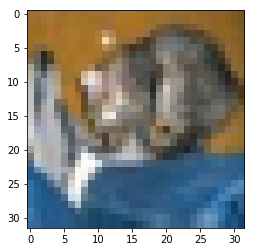

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
i = 0 ## Check for i = 0, 1, 2, 3, 4
plt.imshow(X_test[i]/255.)
plt.show()

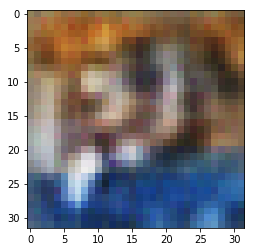

In [27]:
plt.imshow(reconstructions[i])
plt.show()

In [28]:
encoder.save('encoder.h5')
## Unsupervised learning all this while. 

In [29]:
def AutoEncoderSemiSupModel(encoder):
    X = Flatten()(encoder.output)
    X = Dense(10, activation="softmax")(X)
    return Model(encoder.input, X)
autoencsemisup1 = AutoEncoderSemiSupModel(load_model("encoder.h5"))
autoencsemisup2 = AutoEncoderSemiSupModel(load_model("encoder.h5"))

/home/sudeep/.conda/envs/keras_gpu_tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [30]:
X_labelled_n = X_labelled / 255.
X_test_n = X_test / 255.
nvalues = 10
y_labelled_encoded = np.eye(nvalues)[y_labelled]

In [31]:
## Fix all the layers in the model
autoencsemisup2.layers

In [32]:
[autoencsemisup2.layers[i].trainable for i in range(len(autoencsemisup2.layers))]

[False, True, True, True, True, True, True, True, True]

In [33]:
for i in range(len(autoencsemisup2.layers[:-2])):
    autoencsemisup2.layers[i].trainable = False

In [34]:
autoencsemisup2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
autoencsemisup2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 128)         512       
__________

In [35]:
autoencsemisup2.fit(X_labelled_n[:points], y_labelled_encoded[:points], epochs=10, batch_size=128, validation_split=0.20, callbacks = [callback])

Train on 200 samples, validate on 50 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 3.1685 - acc: 0.1100 - val_loss: 2.8910 - val_acc: 0.2600
Epoch 2/10
200/200 [==============================] - 0s 208us/step - loss: 2.4480 - acc: 0.1800 - val_loss: 2.5982 - val_acc: 0.3400
Epoch 3/10
200/200 [==============================] - 0s 284us/step - loss: 1.9253 - acc: 0.3150 - val_loss: 2.4505 - val_acc: 0.3400
Epoch 4/10
200/200 [==============================] - 0s 260us/step - loss: 1.5540 - acc: 0.4600 - val_loss: 2.4190 - val_acc: 0.3400
Epoch 5/10
200/200 [==============================] - 0s 250us/step - loss: 1.2710 - acc: 0.5800 - val_loss: 2.4756 - val_acc: 0.3600
Epoch 6/10
200/200 [==============================] - 0s 270us/step - loss: 1.0500 - acc: 0.6700 - val_loss: 2.5594 - val_acc: 0.3600
Epoch 7/10
200/200 [==============================] - 0s 308us/step - loss: 0.8931 - acc: 0.7250 - val_loss: 2.6437 - val_acc: 0.3600


In [36]:
autoencsemisup2.evaluate(X_test_n, np.eye(nvalues)[y_test])

10000/10000 [==============================] - 2s 210us/step


[2.7939420974731446, 0.2074]

In [37]:
autoencsemisup1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
autoencsemisup1.fit(X_labelled_n[:points], y_labelled_encoded[:points], epochs=10, batch_size=128, validation_split=0.2, callbacks=[callback])
autoencsemisup1.evaluate(X_test_n, np.eye(nvalues)[y_test])

Train on 200 samples, validate on 50 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 3.0859 - acc: 0.1000 - val_loss: 2.4718 - val_acc: 0.1600
Epoch 2/10
200/200 [==============================] - 0s 475us/step - loss: 1.9198 - acc: 0.3250 - val_loss: 2.2121 - val_acc: 0.2600
Epoch 3/10
200/200 [==============================] - 0s 489us/step - loss: 1.2664 - acc: 0.6150 - val_loss: 2.1742 - val_acc: 0.2800
Epoch 4/10
200/200 [==============================] - 0s 668us/step - loss: 0.8420 - acc: 0.7750 - val_loss: 2.2463 - val_acc: 0.2400
Epoch 5/10
200/200 [==============================] - 0s 670us/step - loss: 0.5880 - acc: 0.8650 - val_loss: 2.3309 - val_acc: 0.2400
Epoch 6/10
10000/10000 [==============================] - 2s 224us/step


[2.5251216514587402, 0.2078]

In [38]:
def AutoEncoderSemiSupModel2(encoder):
    #X = Flatten()(encoder.output)
    X = Conv2D(256, (3, 3), activation="relu", padding="SAME")(encoder.output)
    X = Flatten()(X)
    X = Dense(128, activation="relu")(X)
    X = Dense(10, activation="softmax")(X)
    return Model(encoder.input, X)
autoencsemisup = AutoEncoderSemiSupModel2(load_model("encoder.h5"))
for i in range(len(autoencsemisup.layers[:-3])):
    autoencsemisup.layers[i].trainable = False
autoencsemisup.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
autoencsemisup.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 128)         512       
__________

/home/sudeep/.conda/envs/keras_gpu_tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [39]:
autoencsemisup.fit(X_labelled_n[:points], y_labelled_encoded[:points], epochs=10, batch_size=128, validation_split=0.2, callbacks=[callback])

Train on 200 samples, validate on 50 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 2.4796 - acc: 0.1300 - val_loss: 2.1871 - val_acc: 0.1600
Epoch 2/10
200/200 [==============================] - 0s 349us/step - loss: 1.7651 - acc: 0.4450 - val_loss: 2.1810 - val_acc: 0.2000
Epoch 3/10
200/200 [==============================] - 0s 363us/step - loss: 1.2346 - acc: 0.6900 - val_loss: 2.2127 - val_acc: 0.2200
Epoch 4/10
200/200 [==============================] - 0s 470us/step - loss: 0.9161 - acc: 0.7550 - val_loss: 2.3142 - val_acc: 0.2800
Epoch 5/10
200/200 [==============================] - 0s 445us/step - loss: 0.6051 - acc: 0.9100 - val_loss: 2.4649 - val_acc: 0.2800


In [40]:
autoencsemisup1.evaluate(X_test_n, np.eye(nvalues)[y_test])

10000/10000 [==============================] - 2s 216us/step


[2.5251216514587402, 0.2078]

### TASKS

* Can use unlabelled test data for training autoencoder! Try and reason whether or not this helps


* Increase the points variable: 250 -> 1000 -> 5000 -> 10000. Check how extra labelled data impacts performance.

### TSNE

In [50]:
from sklearn.manifold import TSNE
tsne = TSNE()
enc = load_model('encoder.h5')
codes = enc.predict(X_test_n[:1000])

/home/sudeep/.conda/envs/keras_gpu_tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [51]:
codes = np.reshape(codes, [-1, 4*4*128])
codes.shape

(1000, 2048)

In [52]:
projections = tsne.fit_transform(codes)

In [53]:
projections.shape

(1000, 2)

In [54]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource, reset_output, output_notebook
from bokeh.transform import linear_cmap
from bokeh.palettes import d3
from bokeh.models import CategoricalColorMapper

In [55]:
from collections import OrderedDict
CATEGORY_DICT = OrderedDict({
0 : "airplane", 
1: "automobile",
2: "bird",
3:"cat",
4:"deer",
5:"dog",
6:"frog",
7:"horse",
8:"ship",
9:"truck"
})

In [57]:
reset_output()
source = ColumnDataSource(data=dict(
            x=projections[:,0],
            y=projections[:,1],
            labels = [CATEGORY_DICT[i] for i in y_test[:1000]]
        ))
color_map = CategoricalColorMapper(factors=list(CATEGORY_DICT.values()),
                                       palette=d3['Category10'][10])
color = {'field': 'labels', 'transform': color_map}
legend = 'labels'
p = figure(plot_width=1600, plot_height=800,title="TSNE_Projections")
p.circle('x', 'y', source=source, color=color, size=10, legend=legend)
output_file("autoencoder_tsne.html")
show(p)

## TASK:

* Train autoencoder to convergence and then visualise. Use 3-D TSNE 

## GANs

In [48]:
import pickle as pkl

In [49]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [ ]:
def model_inputs(real_dim, z_dim):
    real_input = tf.placeholder(tf.float32, (None, real_dim))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    return real_input, z_input

def generator(z, out_dim, n_units=128, reuse=False,  alpha=0.01):    
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1, alpha*h1)
        # Logits and tanh output
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.nn.tanh(logits)
        return out, logits

def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(h1, alpha*h1)
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.nn.sigmoid(logits)
        return out, logits

# Hyperparameters
input_size = 784 # 28x28 MNIST images flattened
z_size = 100 # Size of latent vector to generator
g_hidden_size = 128 # Size of hidden layer in generator
d_hidden_size = 128 # Size of hidden layer in discriminator
# Leak factor for leaky ReLU
alpha = 0.01

tf.reset_default_graph() 
# Create our input placeholders 
real_input, z = model_inputs(input_size, z_size)  
# Generator network here 
generations, generation_logits = generator(z, input_size, g_hidden_size, reuse=False,  alpha=alpha) 
# g_model is the generator output  

# Disriminator network here 
d_real, d_real_logits = discriminator(real_input, d_hidden_size, reuse=False, alpha=alpha) 
d_fake, d_fake_logits = discriminator(generations, d_hidden_size, reuse=True, alpha=alpha)

In [ ]:
d_labels_real = tf.ones_like(d_real)
d_labels_fake = tf.zeros_like(d_fake)

d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_real, logits=d_real_logits)
d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_fake, logits=d_fake_logits)

d_loss = tf.reduce_mean(d_loss_real + d_loss_fake)

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_fake_logits), logits=d_fake_logits))

In [ ]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith("generator")]
d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

d_train_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)

In [ ]:
batch_size = 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_input: batch_images, z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {z: batch_z, real_input: batch_images})
        train_loss_g = g_loss.eval({z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(z, input_size, reuse=True),
                       feed_dict={z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

In [ ]:
import pickle as pkl
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

In [37]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [49]:
generated_images = np.reshape(samples[-1][0], (-1, 28, 28))

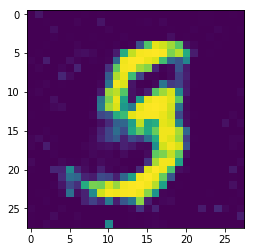

In [60]:
plt.imshow(generated_images[11])

## TASKS:

* Visualise images generated when you do a linear interpolation in noise

### Further Reading:

* DCGAN
* WGAN and WGAN-GP